<a href="https://colab.research.google.com/github/swardiantara/fp-dm-2021/blob/main/CNN_Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
data_traindf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/train.csv')
data_testdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/test.csv')
data_merged = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATMIN/FP/merged.csv')

In [4]:
data_traindf.head()

,sentence #,word,pos,tag,word_idx,tag_idx
0,1,Berikut,PROPN,O,805,4
1,1,adalah,AUX,O,5456,4
2,1,tujuh,NUM,O,3291,4
3,1,kota,NOUN,O,7522,4
4,1,di,ADP,O,2096,4


In [5]:
data_testdf.head()

,sentence #,word,pos,tag,word_idx,tag_idx
0,1,Presiden,PROPN,O,79,4
1,1,terpilih,VERB,O,7980,4
2,1,Joko,PROPN,B-PER,2526,2
3,1,Widodo,PROPN,I-PER,7595,5
4,1,mengungkapkan,VERB,O,3199,4


In [6]:
data_merged.head()

,sentence #,word,pos,tag,word_idx,tag_idx
0,1,Berikut,PROPN,O,805,4
1,1,adalah,AUX,O,5456,4
2,1,tujuh,NUM,O,3291,4
3,1,kota,NOUN,O,7522,4
4,1,di,ADP,O,2096,4


In [7]:
print("Train Shape : ", data_traindf.shape)
print("Test Shape : ", data_testdf.shape)
print("Merged Shape : ", data_merged.shape)

Train Shape :  (30248, 6)
Test Shape :  (18451, 6)
Merged Shape :  (48699, 6)


In [8]:
data_traindf["tag"].value_counts()

O        26728
B-PER      896
B-ORG      721
B-LOC      579
I-ORG      577
I-PER      486
I-LOC      261
Name: tag, dtype: int64

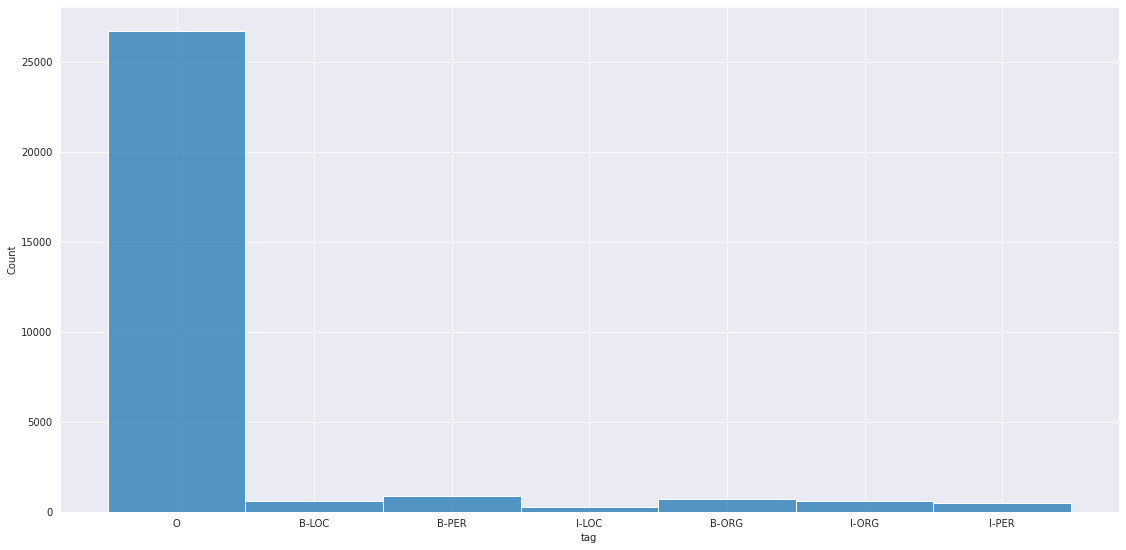

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(data_traindf['tag'])
plt.tight_layout(pad=2)
plt.show()

In [10]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['word'].to_list()))
    else:
        vocab = list(set(data['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok, vocab

In [11]:
token2idx, idx2token, word_vocab = get_dict_map(data_merged, 'token')
tag2idx, idx2tag, tag_vocab = get_dict_map(data_merged, 'tag')
word_vocab.append("ENDPAD")

In [12]:
data_traindf_fillna = data_traindf.fillna(method='ffill', axis=0)
data_testdf_fillna = data_testdf.fillna(method='ffill', axis=0)
data_merged_fillna = data_merged.fillna(method='ffill', axis=0)

In [13]:
data_traindf_group = data_traindf_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))
data_testdf_group = data_testdf_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))
data_merged_group = data_merged_fillna.groupby(["sentence #"], as_index=False)['word','tag','word_idx','tag_idx'].agg(lambda x:list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
data_traindf_group.head()

,sentence #,word,tag,word_idx,tag_idx
0,1,"[Berikut, adalah, tujuh, kota, di, Indonesia, ...","[O, O, O, O, O, B-LOC, O, O, O, O, O, O, O]","[805, 5456, 3291, 7522, 2096, 3518, 4477, 5271...","[4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]"
1,2,"[Soal, calon, presiden, itu, urusan, nanti, ,,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-P...","[528, 7255, 4628, 7226, 2653, 2768, 3948, 4477...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, ..."
2,3,"[Kalau, itu, tanya, PPP, saja, ,, ujar, Nasir,...","[O, O, O, B-ORG, O, O, O, B-PER, O, O, O, O, O...","[4780, 7226, 7466, 827, 3799, 3948, 5916, 2756...","[4, 4, 4, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, ..."
3,4,"[Jokowi, bisa, mengatakan, mencabut, pengaduan...","[B-PER, O, O, O, O, O, O, O, O, O, O]","[8070, 1388, 2557, 3049, 8366, 418, 7443, 3898...","[2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]"
4,5,"[Akbar, menyebutkan, pemerintahan, Jokowi-JK, ...","[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[5096, 2156, 1826, 2562, 7625, 4386, 4784, 200...","[2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [15]:
maxlen_merged = max([len(s) for s in data_merged_group['word_idx'].tolist()])
maxlen_train = max([len(s) for s in data_traindf_group['word_idx'].tolist()])
maxlen_test = max([len(s) for s in data_testdf_group['word_idx'].tolist()])

In [16]:
print("Merged :", maxlen_merged)
print("Train :", maxlen_train)
print("Test :", maxlen_test)

Merged : 112
Train : 69
Test : 94


In [17]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad(dataset_grouped, word_vocab, tag_vocab, maxlen):

    #get max token and tag length
    n_token = len(word_vocab)
    n_tag = len(tag_vocab)

    #Pad tokens (X var)    
    tokens = dataset_grouped['word_idx'].tolist()
    # maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = dataset_grouped['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    # #Split train, test and validation set
    # tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    # train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    # print(
    #     'train_tokens length:', len(train_tokens),
    #     '\ntrain_tags length:', len(train_tags),
    #     '\ntest_tokens length:', len(test_tokens),
    #     '\ntest_tags:', len(test_tags),
    #     '\nval_tokens:', len(val_tokens),
    #     '\nval_tags:', len(val_tags),
    # )
    
    return pad_tokens, pad_tags

In [18]:
train_tokens, train_tags = get_pad(data_traindf_group, word_vocab, tag_vocab, maxlen_merged)
test_tokens,  test_tags = get_pad(data_testdf_group, word_vocab, tag_vocab, maxlen_merged)
train_tags = np.array(train_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'test_tags: ',test_tags.shape)

train_tags:  (1464, 112, 7) test_tags:  (509, 112, 7)


In [19]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

163968


In [20]:
class_weights = class_weight.compute_class_weight(
    class_weight ='balanced', 
    classes = np.unique(train_temp_tags), 
    y = train_temp_tags
    )
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

{0: 32.488210818307905, 1: 0.17441678642432185, 2: 26.142857142857142, 3: 40.596187175043326, 4: 0.876384316073032, 5: 48.19753086419753, 6: 89.74712643678161}
(1464, 112)
(1464, 112)


In [37]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D, Dropout, Input, Reshape, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow import keras

# import keras
# import tensorflow as tf
# from keras.layers import Activation, Conv2D, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
# from keras.layers import MaxPool1D
# from keras.models import Model

filter_sizes = 3
num_filter = 128
input_dim = len(word_vocab)+1
output_dim = 64
input_length = maxlen_merged
n_tags = len(tag2idx)
input_we = len(token2idx)+1

Word2Vec Embedding

In [22]:
from gensim.models import Word2Vec
import os

word_list = data_merged_group['word'].to_list()
model = Word2Vec(word_list, size=100, window=5, min_count=3, iter=100, sg=1)
os.makedirs("models/word_embeddings/w2v", exist_ok=True)
model.save("models/word_embeddings/w2v/w2v")

In [23]:
w2v = model.wv
w2v.similar_by_word('presiden', topn=5)

[('calon', 0.590908408164978),
 ('capres', 0.5018044710159302),
 ('pencalonannya', 0.48803213238716125),
 ('terpilih', 0.4658746123313904),
 ('wakil', 0.4634314477443695)]

In [24]:
w2v.wv['presiden']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


array([ 0.38493338,  0.00855954,  0.01852161, -0.52313966, -0.2370894 ,
        0.2564449 , -0.59877867, -0.18120138, -0.6809101 , -0.55886745,
        1.1483443 , -0.28472978,  0.4958481 ,  0.5531861 ,  0.21994166,
        0.19825035,  0.7875403 , -0.36873996,  0.09564371,  0.6542105 ,
       -0.2663202 ,  0.8065923 , -0.33940908, -0.7147623 ,  0.26904863,
       -0.18254223, -0.04284564,  0.12670635, -0.11694975,  0.3568904 ,
        0.33890498,  0.07402655,  0.11137327,  0.8514843 , -0.3063707 ,
        0.033937  ,  0.6166703 ,  0.6321248 ,  0.11346196,  0.6145625 ,
        0.44197637,  0.29546458, -0.5318821 , -1.15666   , -0.0599479 ,
       -0.502578  , -1.1031543 , -0.12985788,  0.4112276 ,  0.24597315,
        0.25811794, -0.08101126,  0.11337087, -0.30728036, -0.31156227,
        0.19460903,  0.44580588,  0.15587048, -0.30018836,  0.83306056,
        0.5266765 , -1.1770133 ,  0.01513233, -0.84063286,  0.9908059 ,
       -0.29194644,  0.3333145 , -0.59882295,  0.7299533 ,  0.05

In [25]:
from gensim.models import KeyedVectors

embeddings_dictionary = KeyedVectors.load('models/word_embeddings/w2v/w2v')

In [26]:
embedding_matrix = np.zeros((len(token2idx) + 1, 100))
for word, i in token2idx.items():
  try:
    embedding_vector = embeddings_dictionary[word]
  except:
    continue
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [27]:
embedding_matrix.shape

(8543, 100)

In [28]:
embedding_layer = Embedding(input_we,
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=maxlen_merged,
                            trainable=False)

In [58]:
def get_cnn_model():
    # seq_input = tf.keras.Input(shape=(maxlen_merged,), dtype='float32')
    # embedded_seq = embedding_layer(seq_input)
    # conv1 = Conv1D(num_filter, 3, padding='same', activation='relu')(embedded_seq)
    # pool1 = MaxPooling1D(5)(conv1)
    # flat = Flatten()(pool1)
    # dense = Dropout(0.5)(flat)
    # preds = Dense(n_tags, activation="softmax")(dense)
    model = Sequential()
    model.add(embedding_layer)
    # model.add(Embedding(len(token2idx) +1, 100, input_length=maxlen_merged))
    model.add(Conv1D(num_filter, 3, activation='relu',padding='same'))
    # model.add(MaxPooling1D(5))
    # model.add(Conv1D(num_filter, 3, activation='relu',padding='same'))
    # model.add(MaxPooling1D(5))
    # model.add(Conv1D(num_filter, 3, activation='relu',padding='same'))
    # model.add(MaxPooling1D(4))
    # model.add(Flatten())
    model.add(Dropout(0.5))
    model.add((Dense(64, activation="sigmoid")))
    model.add((Dense(n_tags, activation="softmax")))

    # model = Model(seq_input, preds)
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [32]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

# class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 32.488210818307905, 1: 0.17441678642432185, 2: 26.142857142857142, 3: 40.596187175043326, 4: 0.876384316073032, 5: 48.19753086419753, 6: 89.74712643678161}
(1464, 112)


In [59]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

nlp_model = get_cnn_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=25, validation_split=0.2, sample_weight = sample_weights) 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 112, 100)          854300    
                                                                 
 conv1d_18 (Conv1D)          (None, 112, 128)          38528     
                                                                 
 dropout_10 (Dropout)        (None, 112, 128)          0         
                                                                 
 dense_19 (Dense)            (None, 112, 64)           8256      
                                                                 
 dense_20 (Dense)            (None, 112, 7)            455       
                                                                 
Total params: 901,539
Trainable params: 47,239
Non-trainable params: 854,300
_________________________________________________________________
Epoch 1/25
19/19 [========================

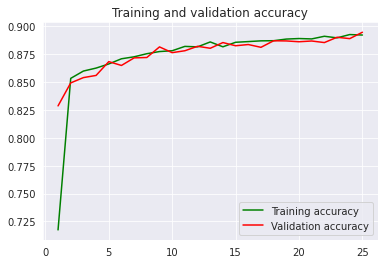

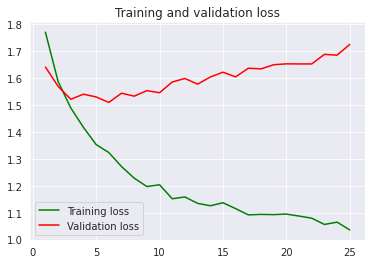

In [60]:
# Plot results
import matplotlib.pyplot as plt

accuracy = his.history['accuracy']
val_acc = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']

epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [61]:
y_pred = nlp_model.predict(test_tokens)
y_pred = np.argmax(y_pred, axis=-1)

In [62]:
y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(509, 112) (509, 112)
16/16 [==============================] - 0s 13ms/step - loss: 1.0606 - accuracy: 0.8281


[1.060571551322937, 0.8281294107437134]

In [63]:
y_test_list = []
y_pred_list = []
for row in range(0, y_test.shape[0]):
  y_pred_list = np.concatenate((y_pred_list, y_pred[row]), axis=0)
  y_test_list = np.concatenate((y_test_list, y_test[row]), axis=0)
  # y_test_list = y_test_list + y_test[row]

In [64]:
data_prediction = pd.DataFrame({'actual_class': y_test_list, 'predicted_class': y_pred_list})
data_prediction['actual_class'] = data_prediction['actual_class'].map(idx2tag)
data_prediction['predicted_class'] = data_prediction['predicted_class'].map(idx2tag)

In [65]:
data_prediction

,actual_class,predicted_class
0,B-ORG,B-ORG
1,B-ORG,B-ORG
2,B-PER,B-PER
3,B-LOC,O
4,B-ORG,O
...,...,...
57003,O,O
57004,O,O
57005,O,O
57006,O,O


In [66]:
confusion_matrix = pd.crosstab(data_prediction['predicted_class'], data_prediction['actual_class'])
confusion_matrix

actual_class,B-LOC,B-ORG,B-PER,I-LOC,I-ORG,I-PER,O
predicted_class,,,,,,,
B-LOC,106,339,51,5,9,4,2
B-ORG,75,7625,115,44,17,68,36
B-PER,18,1510,283,5,3,53,39
I-LOC,2,493,11,202,11,14,34
I-ORG,37,746,53,41,80,35,24
I-PER,4,454,22,4,4,286,49
O,90,4801,201,110,35,130,38628


In [67]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(data_prediction['actual_class'], data_prediction['predicted_class'], output_dict=True)).T

,precision,recall,f1-score,support
B-LOC,0.205426,0.319277,0.250000,332.000000
B-ORG,0.955514,0.477518,0.636796,15968.000000
B-PER,0.148090,0.384511,0.213827,736.000000
I-LOC,0.263364,0.491484,0.342954,411.000000
I-ORG,0.078740,0.503145,0.136170,159.000000
I-PER,0.347509,0.484746,0.404812,590.000000
O,0.878009,0.995259,0.932965,38812.000000
accuracy,0.828129,0.828129,0.828129,0.828129
macro avg,0.410950,0.522277,0.416789,57008.000000
weighted avg,0.874227,0.828129,0.824804,57008.000000
